In [1]:
import numpy as np
import scipy.io
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

def dataloader(path):
    data = scipy.io.loadmat(path)
    AF = data['AF']
    modified_rows1 = AF[:-2]
    last_rows1 = AF[-2:]
    CF = data['CF']
    c = np.concatenate((modified_rows1, CF,last_rows1), axis=0)
    x = c[0:-2]; y = c[-2]; w = c[-1];
    return x.T, y.T, w.T, data['CF_info']

def calculate_accuracy(arr1, arr2):
    count = sum(1 for itr1, itr2 in zip(arr1, arr2) if itr1 == itr2)
    return count / len(arr1)

def normalization(feats):
    df = pd.DataFrame(feats)
    scaler = StandardScaler()
    x_new = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    return x_new

def make_partitions(arr_words, arr_labels):
    v = []
    temp = []

    for i in range(len(arr_words) - 1):
        word = arr_words[i]
        next_word = arr_words[i + 1]
        temp.append(arr_labels[i])

        if word != next_word or i == len(arr_words) - 2:
            if i == len(arr_words) - 2:
                temp.append(arr_labels[i + 1])

            numpy_temp = np.array(temp)
            temp_max = np.amax(numpy_temp)
            numpy_temp = np.divide(numpy_temp, temp_max)
            v = np.concatenate((v, numpy_temp), axis=None)
            temp.clear()

    v1 = [1 if i == 1 else 0 for i in v]
    return v1
    
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim = 38
train_path = filee; test_path = filee.replace('train','test')
xtrain, ytrain, wtrain1, info_train1 = dataloader(train_path);
xtest, ytest, wtest1, info_test1 = dataloader(test_path);
xtest= normalization(xtest)
xtrain= normalization(xtrain)

woPP=[]; wPP=[]
input_shape1 = (19,1)
input_shape2 = (38,1)
temperature = 0.03
learning_rate=0.001

2023-06-15 06:09:56.157065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim=38

train_path = filee; test_path = filee.replace('train','test')
xtrainG, ytrainG, wtrain1, info_train1 = dataloader(train_path);
xtestG, ytestG, wtest1, info_test1 = dataloader(test_path);
xtestG = normalization(xtestG)
xtrain1G = normalization(xtrainG)

fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'ITA_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim=38

train_path = filee; test_path = filee.replace('train','test')
xtrainI, ytrainI, wtrain1, info_train1 = dataloader(train_path);
xtestI, ytestI, wtest1, info_test1 = dataloader(test_path);
xtestI = normalization(xtestI)
xtrainI = normalization(xtrainI)


# Implementing Contrastive Loss (N-Pair)

In [4]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=temperature, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        print(feature_vectors.shape)
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)), self.temperature)
        return 0.35*(tfa.losses.npairs_loss(tf.squeeze(labels), logits))

In [17]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xtrainG, ytrainG, test_size=0.2, random_state=42)
input_shape = (38,1)

In [18]:
class Encoder(Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    input_shape = (38,1)
    self.latent_dim = latent_dim 
    inputs = Input(shape=(38,1))
    outputs = inputs  
    self.encoder = tf.keras.Sequential([
      inputs,
      
      layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(0.5),
      layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

latent_dim=30

def create_encoder():
    return Encoder(latent_dim)


def add_projection_head(Encoder):
    inp = keras.Input(shape=input_shape)
    hidden  = Encoder(inp)
    features = layers.Dense(16, activation="relu")(hidden)
    model = keras.Model(
        inputs=inp, outputs=features, name="cifar-encoder_with_projection-head"
    )
    return model

encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(xtra_a, ytra_a , validation_data =(xval_a,yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 38, 1)]           0         
                                                                 
 encoder_4 (Encoder)         (None, 30)                38910     
                                                                 
 dense_9 (Dense)             (None, 16)                496       
                                                                 
Total params: 39,406
Trainable params: 39,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
(None, 16)
(None, 16)
148/148 [==============================] - 2s 5ms/step - loss: 1.2371 - val_loss: 1.2116
Epoch 2/100
148/148 [==============================] - 1s 5ms/step - loss: 1.2115 - val_loss: 1.2092
Epoch 3/100
148/148 [==============================] - 1s 4ms/step -

In [19]:
trainoutputs = encoder_with_projection_head.predict(xtrainG)

185/185 [==============================] - 0s 1ms/step


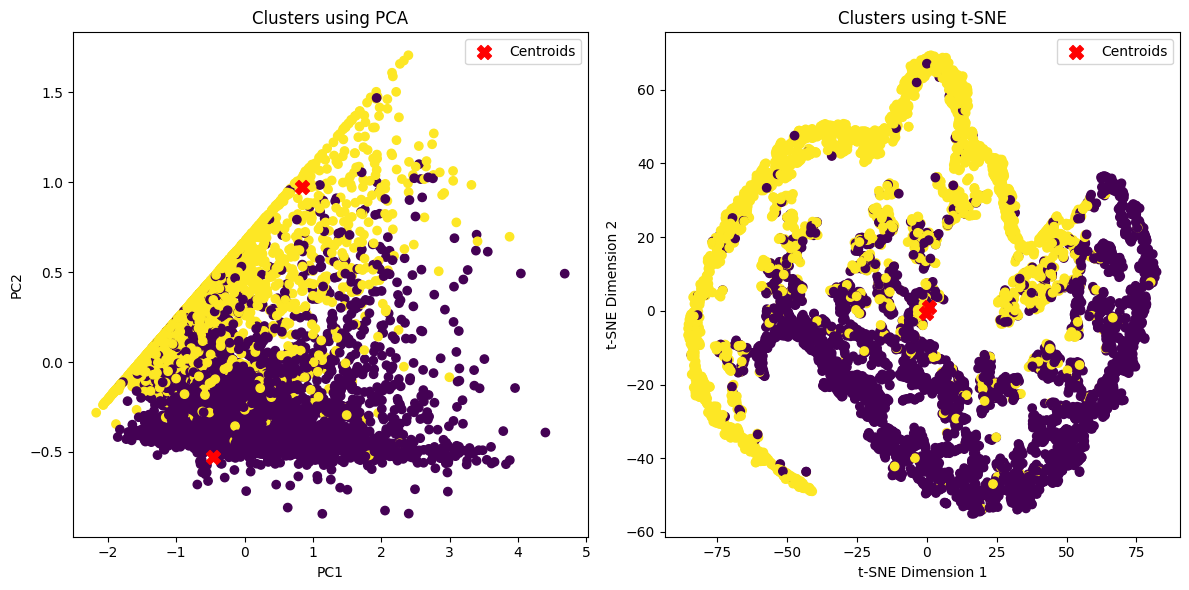

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming xtrain is your input data with shape (5891, 38)
# Assuming labels_binary is the cluster labels assigned by DBSCAN
# Assuming centroids is a numpy array containing the centroid coordinates

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainoutputs)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(trainoutputs)

# Plot clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrainG, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot clusters using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ytrainG, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=100, label='Centroids')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Combined

In [9]:
fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim=38

train_path = filee; test_path = filee.replace('train','test')
xtrainG, ytrainG, wtrain1, info_train1 = dataloader(train_path);
xtestG, ytestG, wtest1, info_test1 = dataloader(test_path);
xtestG = normalization(xtestG)
xtrain1G = normalization(xtrainG)

fatyp = 'TypicalFA_comb1'
drivepath = 'finalData/'+ fatyp +'/';
#featFiles = 'GER_train_fisher-2000_FA_GT_ESTphnTrans_estStress'               #glob.glob(drivepath + '*train*')
filee = drivepath+'ITA_train_fisher-2000_FA_GT_ESTphnTrans_estStress.mat'
original_dim=38

train_path = filee; test_path = filee.replace('train','test')
xtrainI, ytrainI, wtrain1, info_train1 = dataloader(train_path);
xtestI, ytestI, wtest1, info_test1 = dataloader(test_path);
xtestI = normalization(xtestI)
xtrainI = normalization(xtrainI)

xfinal = np.concatenate((xtrainG, xtrainI), axis=0)
yfinal=np.concatenate((ytrainG, ytrainI), axis=None)

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xfinal, yfinal, test_size=0.2, random_state=42)
input_shape = (38,1)


class Encoder(Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    input_shape = (38,1)
    self.latent_dim = latent_dim 
    inputs = Input(shape=(38,1))
    outputs = inputs  
    self.encoder = tf.keras.Sequential([
      inputs,
      
      layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(0.5),
      layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

latent_dim=30

def create_encoder():
    return Encoder(latent_dim)


def add_projection_head(Encoder):
    inp = keras.Input(shape=input_shape)
    hidden  = Encoder(inp)
    features = layers.Dense(16, activation="relu")(hidden)
    model = keras.Model(
        inputs=inp, outputs=features, name="cifar-encoder_with_projection-head"
    )
    return model

encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(xtra_a, ytra_a , validation_data =(xval_a,yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 38, 1)]           0         
                                                                 
 encoder_1 (Encoder)         (None, 30)                38910     
                                                                 
 dense_3 (Dense)             (None, 16)                496       
                                                                 
Total params: 39,406
Trainable params: 39,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
(None, 16)
(None, 16)
287/287 [==============================] - 3s 5ms/step - loss: 1.2231 - val_loss: 1.1962
Epoch 2/100
287/287 [==============================] - 1s 4ms/step - loss: 1.2007 - val_loss: 1.1915
Epoch 3/100
287/287 [==============================] - 1s 4ms/step -

174/174 [==============================] - 0s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


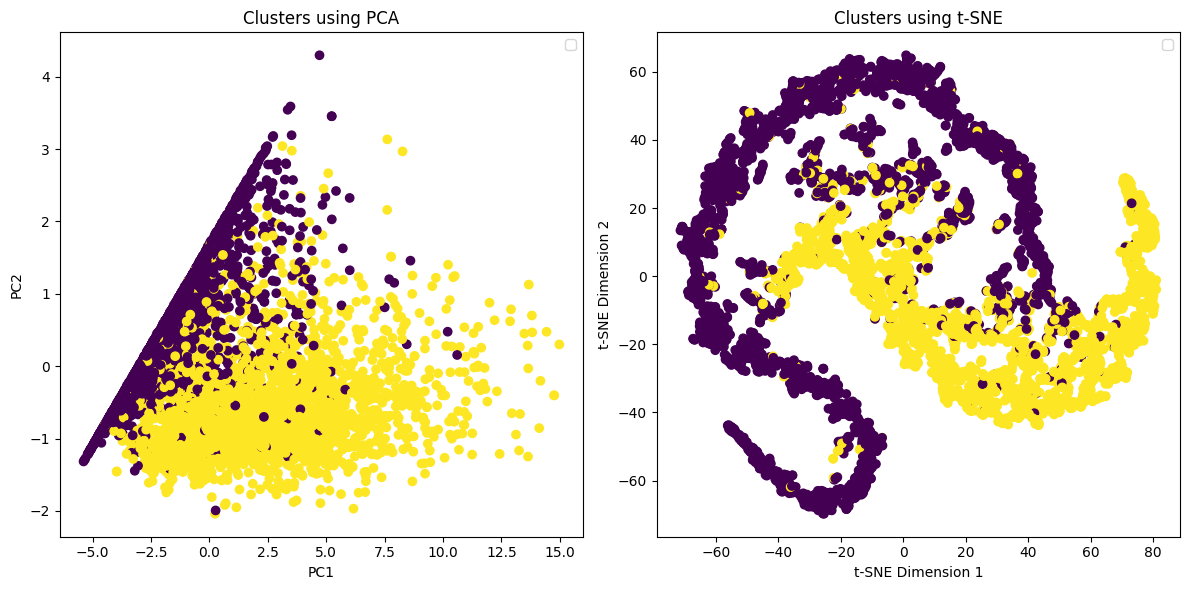

In [11]:
trainoutputs = encoder_with_projection_head.predict(xtrainI)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming xtrain is your input data with shape (5891, 38)
# Assuming labels_binary is the cluster labels assigned by DBSCAN
# Assuming centroids is a numpy array containing the centroid coordinates

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainoutputs)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(trainoutputs)

# Plot clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrainI, cmap='viridis')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot clusters using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ytrainI, cmap='viridis')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

185/185 [==============================] - 0s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


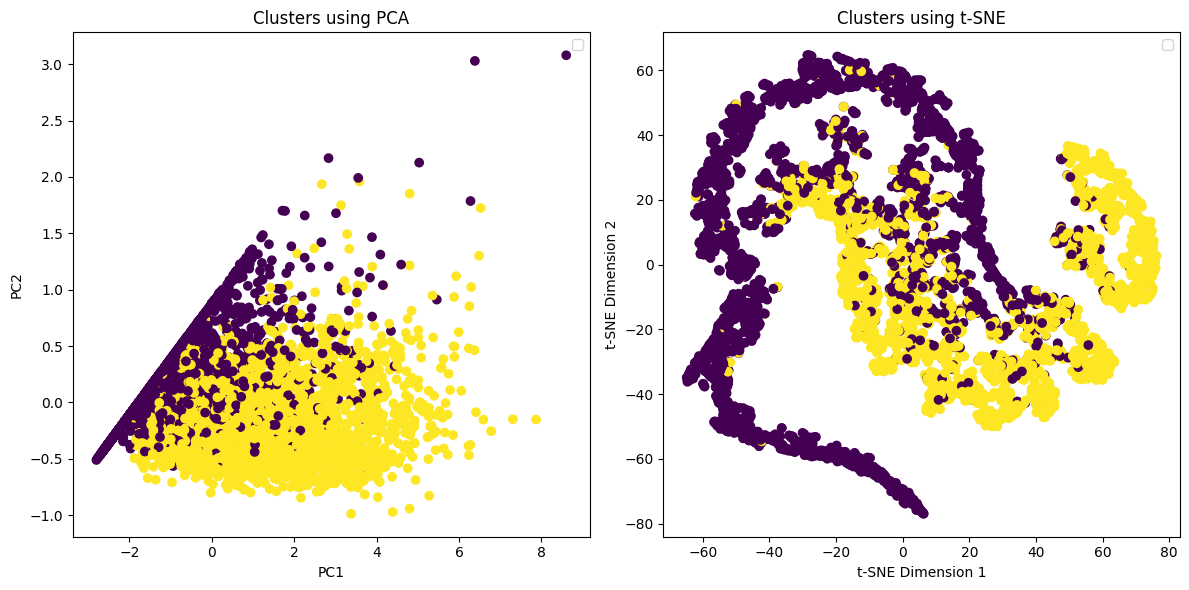

In [12]:
trainoutputs = encoder_with_projection_head.predict(xtrainG)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming xtrain is your input data with shape (5891, 38)
# Assuming labels_binary is the cluster labels assigned by DBSCAN
# Assuming centroids is a numpy array containing the centroid coordinates

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainoutputs)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(trainoutputs)

# Plot clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrainG, cmap='viridis')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot clusters using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ytrainG, cmap='viridis')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

# Cross

In [13]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xtrainG, ytrainG, test_size=0.2, random_state=42)
input_shape = (38,1)


class Encoder(Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    input_shape = (38,1)
    self.latent_dim = latent_dim 
    inputs = Input(shape=(38,1))
    outputs = inputs  
    self.encoder = tf.keras.Sequential([
      inputs,
      
      layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(0.5),
      layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

latent_dim=30

def create_encoder():
    return Encoder(latent_dim)


def add_projection_head(Encoder):
    inp = keras.Input(shape=input_shape)
    hidden  = Encoder(inp)
    features = layers.Dense(16, activation="relu")(hidden)
    model = keras.Model(
        inputs=inp, outputs=features, name="cifar-encoder_with_projection-head"
    )
    return model

encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(xtra_a, ytra_a , validation_data =(xval_a,yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 38, 1)]           0         
                                                                 
 encoder_2 (Encoder)         (None, 30)                38910     
                                                                 
 dense_5 (Dense)             (None, 16)                496       
                                                                 
Total params: 39,406
Trainable params: 39,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
(None, 16)
(None, 16)
148/148 [==============================] - 4s 7ms/step - loss: 1.2186 - val_loss: 1.2039
Epoch 2/100
148/148 [==============================] - 1s 6ms/step - loss: 1.2012 - val_loss: 1.1957
Epoch 3/100
148/148 [==============================] - 1s 5ms/step -

174/174 [==============================] - 0s 1ms/step


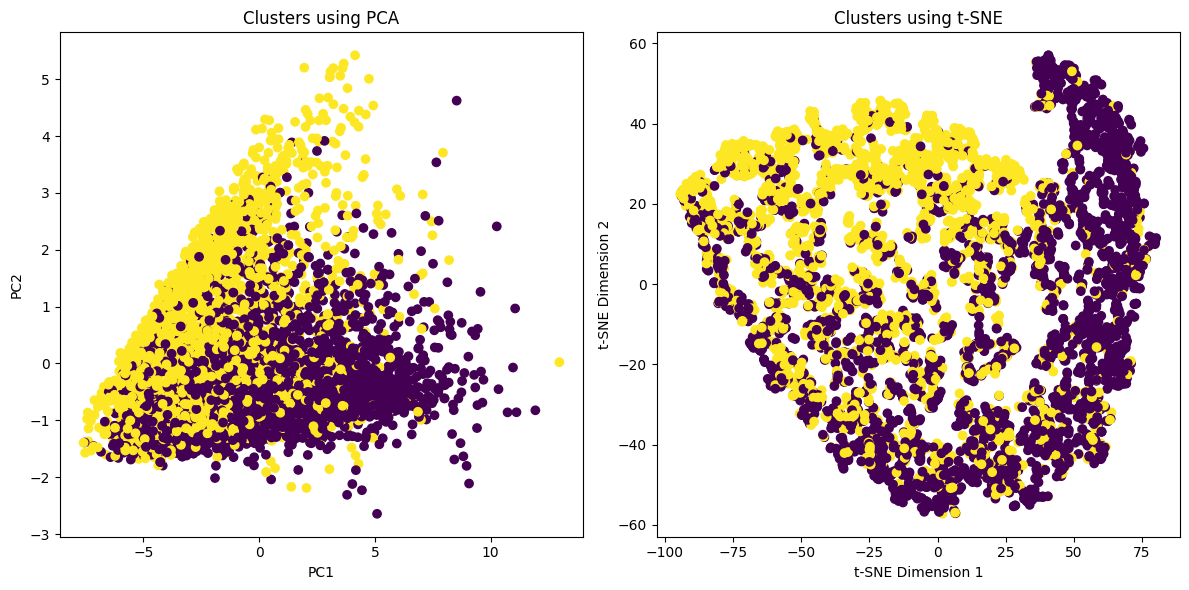

In [14]:
# Assuming xtrain is your input data with shape (5891, 38)
# Assuming labels_binary is the cluster labels assigned by DBSCAN
# Assuming centroids is a numpy array containing the centroid coordinates
trainoutputs = encoder_with_projection_head.predict(xtrainI)
# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainoutputs)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(trainoutputs)

# Plot clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrainI, cmap='viridis')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plot clusters using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ytrainI, cmap='viridis')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Display the plot
plt.tight_layout()
plt.show()


In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Input, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
xtra_a, xval_a, ytra_a, yval_a = train_test_split(xtrainI, ytrainI, test_size=0.2, random_state=42)
input_shape = (38,1)


class Encoder(Model):
  def __init__(self, latent_dim):
    super(Encoder, self).__init__()
    input_shape = (38,1)
    self.latent_dim = latent_dim 
    inputs = Input(shape=(38,1))
    outputs = inputs  
    self.encoder = tf.keras.Sequential([
      inputs,
      
      layers.Conv1D(filters=64, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(0.5),
      layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
      layers.MaxPooling1D(pool_size=1),
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    return encoded

latent_dim=30

def create_encoder():
    return Encoder(latent_dim)


def add_projection_head(Encoder):
    inp = keras.Input(shape=input_shape)
    hidden  = Encoder(inp)
    features = layers.Dense(16, activation="relu")(hidden)
    model = keras.Model(
        inputs=inp, outputs=features, name="cifar-encoder_with_projection-head"
    )
    return model

encoder = create_encoder()
encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(optimizer=keras.optimizers.Adam(learning_rate),loss=SupervisedContrastiveLoss(temperature))
encoder_with_projection_head.summary()
history = encoder_with_projection_head.fit(xtra_a, ytra_a , validation_data =(xval_a,yval_a), batch_size=32, epochs=100, callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)])

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 38, 1)]           0         
                                                                 
 encoder_3 (Encoder)         (None, 30)                38910     
                                                                 
 dense_7 (Dense)             (None, 16)                496       
                                                                 
Total params: 39,406
Trainable params: 39,406
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
(None, 16)
(None, 16)
140/140 [==============================] - 2s 5ms/step - loss: 1.2728 - val_loss: 1.2030
Epoch 2/100
140/140 [==============================] - 1s 4ms/step - loss: 1.1986 - val_loss: 1.1846
Epoch 3/100
140/140 [==============================] - 1s 5ms/step -

185/185 [==============================] - 1s 2ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


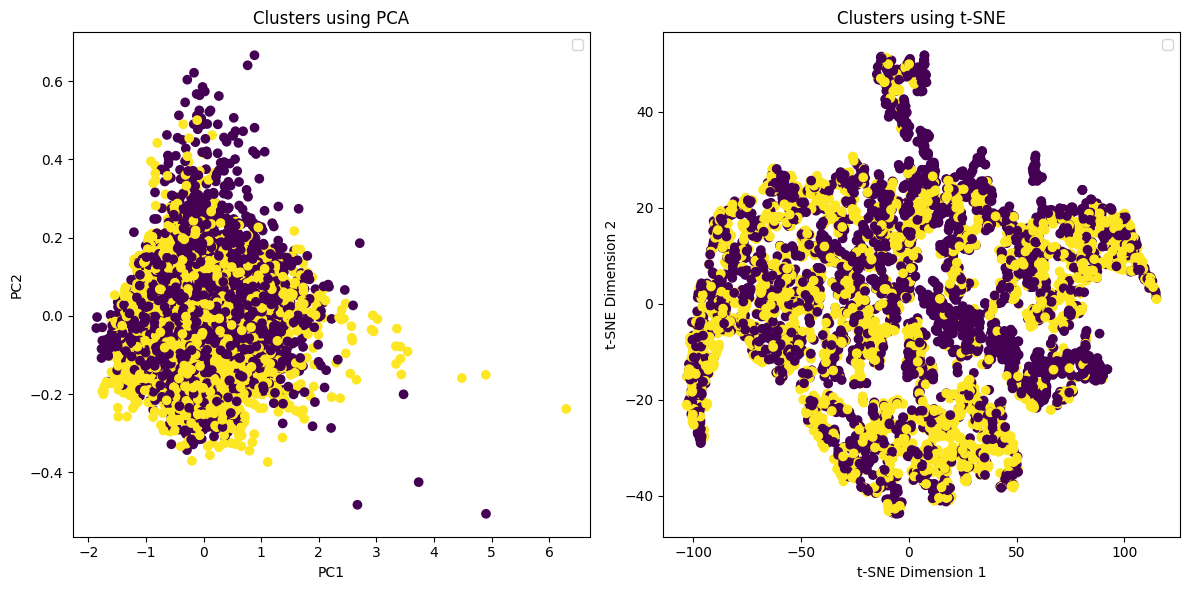

In [16]:
trainoutputs = encoder_with_projection_head.predict(xtrainG)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming xtrain is your input data with shape (5891, 38)
# Assuming labels_binary is the cluster labels assigned by DBSCAN
# Assuming centroids is a numpy array containing the centroid coordinates

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(trainoutputs)

# Perform t-SNE
tsne = TSNE(n_components=2, perplexity=30)
tsne_result = tsne.fit_transform(trainoutputs)

# Plot clusters using PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=ytrainG, cmap='viridis')
plt.title('Clusters using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Plot clusters using t-SNE
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=ytrainG, cmap='viridis')
plt.title('Clusters using t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()